# Vaccinatie-/Misinformatie-Classifier
## ...

(hier komt wat uitleg waar dit over gaat en wat het is).


In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from math import log, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import numpy as np
import glob
import os
from collections import Counter
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from string import punctuation
import eli5

STOPWORDS = get_stop_words('dutch')

### 1. Define functions for preprocessing and data retrieval

In [28]:
def preprocess(doc):
    if type(doc) is str:
        doc = doc.lower()
        doc = doc.translate(str.maketrans({key: " " for key in string.punctuation}))
        doc = " ".join([w for w in doc.split() if w not in STOPWORDS])
        return doc
    else:
        print('Received non-string input, returning empty string')
        return ''

In [29]:
def get_traintest(df, test_size=.30):
    '''takes dataframe, selects relevant part, preprocesses text and returns train, test data lists with 
    (text, label) tuples'''
    rows = df[['Platte tekst (zonder opmaak)','Misinfo Nee(1) Ja(0)']].dropna().to_records(index=False)
    rowsclean = []
    for e in rows:
        try:
            rowsclean.append((preprocess(e[0]), abs(int(e[1])-1)))  # we now code misinfo as 1 and legitimate as 0
        except ValueError:
            pass
    if test_size < 1:
        train, test = train_test_split(rowsclean, test_size=test_size)
        return train, test
    if test_size == 1:
        return [], rowsclean


### 2. Read data

We have two datasets: one on childhood vaccination on which we train and test, and one on HPV that we use for testing out-of-sample prediction only

In [30]:
hpv = pd.read_csv('hpv.csv')
childhood = pd.read_csv('childhood.csv')

In [31]:
childhood_train, childhood_test = get_traintest(childhood)
print("Obtained {} train and {} test tuples for childhood vaccination".format(len(childhood_train), len(childhood_test)))

hpv_train, hpv_test = get_traintest(hpv, test_size=1)
print("Obtained {} train and {} test tuples for HPV".format(len(hpv_train), len(hpv_test)))

Obtained 316 train and 136 test tuples for childhood vaccination
Obtained 0 train and 198 test tuples for HPV


### 3. Define Machine Learning-functions

In [32]:
def ml(train, test):
    myvec = TfidfVectorizer()
    train_features = myvec.fit_transform([e[0] for e in train])
    test_features = myvec.transform([e[0] for e in test])
    model  = LogisticRegression()
    model.fit(train_features, [e[1] for e in train])
    predictions = model.predict(test_features)
    predicted_probabilities = model.predict_proba(test_features)
    return predictions, predicted_probabilities

In [33]:
def performance(predictions, actual_scores):
    accuracy=metrics.accuracy_score(actual_scores,predictions,normalize=True)
    recall_misinfo=metrics.recall_score(actual_scores,predictions,pos_label=1)
    recall_legitimate=metrics.recall_score(actual_scores,predictions,pos_label=0)
    precision_misinfo=metrics.precision_score(actual_scores,predictions,pos_label=1)
    precision_legitimate=metrics.precision_score(actual_scores,predictions,pos_label=0)
    confusionmatrix=metrics.confusion_matrix(actual_scores,predictions)
    print('Accuracy:',accuracy,
          '\nRecall (misinfo):',recall_misinfo,
          '\nPrecision (misinfo):',precision_misinfo,
          '\nRecall (legitimate):',recall_legitimate,
          '\nPrecision (legitimate) ',precision_legitimate,
          '\nConfusion Matrix:','\n',confusionmatrix)


In [34]:
def roc_curve(predicted_probabilities, actual_scores):
    fpr, tpr, thresholds = metrics.roc_curve(actual_scores, predicted_probabilities[:,1],pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC:\n{}".format(roc_auc))
    #%%
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Accuracy: 0.8823529411764706 
Recall (misinfo): 0.7627118644067796 
Precision (misinfo): 0.9574468085106383 
Recall (legitimate): 0.974025974025974 
Precision (legitimate)  0.8426966292134831 
Confusion Matrix: 
 [[75  2]
 [14 45]]
ROC AUC:
0.978648470173894


/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


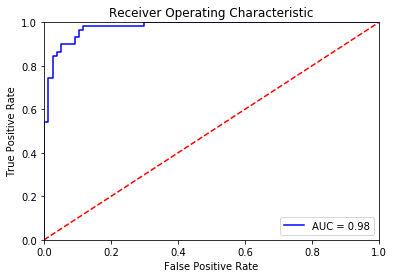

In [35]:
predictions, probabilities = ml(childhood_train, childhood_test)
performance(predictions, [e[1] for e in childhood_test])
roc_curve(probabilities, [e[1] for e in childhood_test])

## Feature Weights

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

vec = TfidfVectorizer()
clf = LogisticRegression()
pipe = make_pipeline(vec, clf)
pipe.fit([r[0] for r in childhood_train], [r[1] for r in childhood_train])

predictions = pipe.predict([r[0] for r in childhood_test])

/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [46]:
eli5.show_weights(pipe,top=20)

Weight?,Feature
+1.007,we
+0.767,www
+0.760,onderzoek
+0.740,vaccinatieschade
+0.690,dr
+0.687,immuunsysteem
+0.677,vaccins
+0.664,aluminium
+0.636,bijsluiter
+0.596,astma


In [52]:
eli5.show_prediction(clf, hpv_test[2][0],vec=vec)

## Oud of sample prediction

Accuracy: 0.7626262626262627 
Recall (misinfo): 0.3181818181818182 
Precision (misinfo): 0.9130434782608695 
Recall (legitimate): 0.9848484848484849 
Precision (legitimate)  0.7428571428571429 
Confusion Matrix: 
 [[130   2]
 [ 45  21]]
ROC AUC:
0.8895775941230487


/home/damian/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


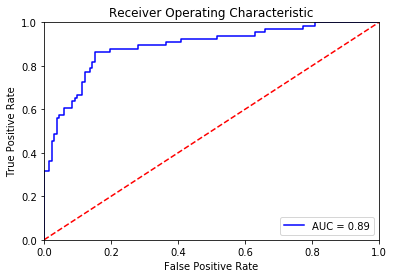

In [36]:
predictions, probabilities = ml(childhood_train, hpv_test)
performance(predictions, [e[1] for e in hpv_test])
roc_curve(probabilities, [e[1] for e in hpv_test])

# oude scratch

In [ ]:
#Count_NB
#train & show performance
m1_nb = MultinomialNB()
m1_nb.fit(train_features_count, train_scores)
m1_predictions = m1_nb.predict(test_features_count)
performance(m1_predictions)
#%%
#Save
pk.dump(count_vectorizer,open('count_vectorizer.pkl',mode='wb'))
joblib.dump(m1_nb,'nb_classifier_count.pkl')
#%%
#tf-idf_NB
m2_nb = MultinomialNB()
m2_nb.fit(train_features_tfidf, train_scores)
m2_predictions = m2_nb.predict(test_features_tfidf)
performance(m2_predictions)
#%%
pk.dump(tfidf_vectorizer,open('tfidf_vectorizer.pkl',mode='wb'))
joblib.dump(m2_nb,'nb_classifier_tfidf.pkl')
#%%
#Count_LR
m3_logreg = LogisticRegression()
m3_logreg.fit(train_features_count, train_scores)
m3_predictions = m3_logreg.predict(test_features_count)
performance(m3_predictions)
#%%
joblib.dump(m3_logreg, 'logreg_classifier.pkl')
#%%
#tf-idf_LR
m4_logreg = LogisticRegression()
m4_logreg.fit(train_features_tfidf, train_scores)
m4_predictions = m4_logreg.predict(test_features_tfidf)
performance(m4_predictions)
#%%
joblib.dump(m4_logreg, 'logreg_classifier_tfidf.pkl')
#%%
#make ROCs
m1_predict_probabilities = m1_nb.predict_proba(test_features_count)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m1_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%
m2_predict_probabilities = m2_nb.predict_proba(test_features_tfidf)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m2_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%
m3_predict_probabilities = m3_logreg.predict_proba(test_features_count)
fpr, tpr, thresholds = metrics.roc_curve(actual_scores, m3_predict_probabilities[:,1],pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:\n{}".format(roc_auc))
#%%